# 03: M1/S1 - Unsupervised Anomaly Detection (Token Level)

**Goal:** Detect subjective words (LJMPNIK) using unsupervised methods (Mahalanobis, Isolation Forest, OCSVM).

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itables import show
import sys
import os
from tqdm.notebook import tqdm

from sklearn.metrics import precision_recall_curve, auc, classification_report

# Auto-reload modules for development
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add src to path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

# Import custom modules
import config
import data_splitting
import models
import visualization
import experiments
import evaluation


# Setup visualization style
visualization.setup_style()

print(f"✅ Setup complete. Data dir: {config.DATA_DIR}")


⚙️ Configuration loaded. Device: cpu


2026-02-04 11:17:09,616 - INFO - 🎨 Visualization style set: whitegrid


✅ Setup complete. Data dir: C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data


## 2. Data Check

In [14]:
# Definice kombinací k prozkoumání
SCENARIOS = ['baseline', 'robustness']
FILTERS = ['aggressive', 'mild', 'none']

print(f"{'='*90}")
print(f"📊 DATA CHECK REPORT (M1 - Unsupervised)")
print(f"{'='*90}")

for scenario in SCENARIOS:
    for filter_type in FILTERS:
        print(f"\n🔹 SCÉNÁŘ: {scenario.upper()} | FILTER: {filter_type.upper()}")
        print(f"{'-'*90}")
        
        try:
            # 1. Načtení dat přes modul
            data = data_splitting.get_unsupervised_splits(
                scenario=scenario,
                level='token',
                filter_type=filter_type,
                pooling='mean', # U token level ignorováno
                random_state=42
            )
            
            # 2. Pomocná funkce pro formátování řádku
            def print_stats(name, X, y):
                n_total = X.shape[0]
                n_dims = X.shape[1]
                n_l0 = np.sum(y == 0)
                n_l1 = np.sum(y == 1)
                
                # Poměr (aby nám to nehodilo error dělení nulou)
                ratio_str = f"{n_l0 / n_l1:.2f}" if n_l1 > 0 else "Inf"
                
                print(f"   {name:<6} | Shape: ({n_total:5}, {n_dims}) | Balance: L0={n_l0:<4} vs L1={n_l1:<4} | Ratio L0/L1: {ratio_str:>5}")

            # 3. Výpis statistik
            print_stats("TRAIN", data['X_train'], data['y_train'])
            print_stats("VAL",   data['X_val'],   data['y_val'])
            print_stats("TEST",  data['X_test'],  data['y_test'])
            
            # 4. Logické kontroly (Sanity Checks)
            # A) Train musí být čistý
            if np.sum(data['y_train'] == 1) > 0:
                print("      ⚠️ VAROVÁNÍ: Train set obsahuje anomálie! (Měl by být L0 only)")
            
            # B) Robustness test by měl být větší než Baseline test
            if scenario == 'robustness' and np.sum(data['y_test'] == 1) < 100:
                print("      ⚠️ VAROVÁNÍ: Robustness Test má málo anomálií (načetla se Silver data?)")

        except Exception as e:
            print(f"   ❌ CHYBA: {e}")
            # Často u 'none' může dojít paměť nebo chybět config, tak ať to vidíme

2026-02-04 11:29:15,261 - INFO - 📊 Preparing scenario: baseline (token level, aggressive filter)


📊 DATA CHECK REPORT (M1 - Unsupervised)

🔹 SCÉNÁŘ: BASELINE | FILTER: AGGRESSIVE
------------------------------------------------------------------------------------------


2026-02-04 11:29:16,556 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-04 11:29:24,022 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-04 11:29:24,194 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-04 11:29:24,210 - INFO - ✅ Document-level split completed:
2026-02-04 11:29:24,210 - INFO -    Train: 376 docs, 2585 samples
2026-02-04 11:29:24,226 - INFO -    Val:   41 docs, 270 samples
2026-02-04 11:29:24,230 - INFO -    Test:  103 docs, 741 samples
2026-02-04 11:29:24,236 - INFO -    ✓ No document leakage detected between splits
2026-02-04 11:29:24,239 - INFO - ✅ Scenario data prepared:
2026-02-04 11:29:24,244 - INFO -    Train: 2585 samples (L0: 900, L1: 1685)
2026-02-04 11:29:24,246 - INFO -    Val:   270 samples (L0: 96, L1: 174)
2026-02-04 11:29:24,249 - INFO -    Test:  741 samples (L0

   TRAIN  | Shape: (  900, 768) | Balance: L0=900  vs L1=0    | Ratio L0/L1:   Inf
   VAL    | Shape: (  270, 768) | Balance: L0=250  vs L1=20   | Ratio L0/L1: 12.50
   TEST   | Shape: (  741, 768) | Balance: L0=695  vs L1=46   | Ratio L0/L1: 15.11

🔹 SCÉNÁŘ: BASELINE | FILTER: MILD
------------------------------------------------------------------------------------------


2026-02-04 11:29:25,234 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-04 11:29:28,687 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-04 11:29:28,759 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-04 11:29:28,771 - INFO - ✅ Document-level split completed:
2026-02-04 11:29:28,771 - INFO -    Train: 376 docs, 2654 samples
2026-02-04 11:29:28,776 - INFO -    Val:   41 docs, 278 samples
2026-02-04 11:29:28,776 - INFO -    Test:  103 docs, 755 samples
2026-02-04 11:29:28,779 - INFO -    ✓ No document leakage detected between splits
2026-02-04 11:29:28,782 - INFO - ✅ Scenario data prepared:
2026-02-04 11:29:28,786 - INFO -    Train: 2654 samples (L0: 918, L1: 1736)
2026-02-04 11:29:28,792 - INFO -    Val:   278 samples (L0: 97, L1: 181)
2026-02-04 11:29:28,797 - INFO -    Test:  755 samples (L0

   TRAIN  | Shape: (  918, 768) | Balance: L0=918  vs L1=0    | Ratio L0/L1:   Inf
   VAL    | Shape: (  278, 768) | Balance: L0=258  vs L1=20   | Ratio L0/L1: 12.90
   TEST   | Shape: (  755, 768) | Balance: L0=707  vs L1=48   | Ratio L0/L1: 14.73

🔹 SCÉNÁŘ: BASELINE | FILTER: NONE
------------------------------------------------------------------------------------------


2026-02-04 11:29:29,402 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-04 11:29:31,833 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-04 11:29:31,849 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-04 11:29:31,860 - INFO - ✅ Document-level split completed:
2026-02-04 11:29:31,860 - INFO -    Train: 376 docs, 4369 samples
2026-02-04 11:29:31,860 - INFO -    Val:   41 docs, 454 samples
2026-02-04 11:29:31,865 - INFO -    Test:  103 docs, 1246 samples
2026-02-04 11:29:31,869 - INFO -    ✓ No document leakage detected between splits
2026-02-04 11:29:31,869 - INFO - ✅ Scenario data prepared:
2026-02-04 11:29:31,871 - INFO -    Train: 4369 samples (L0: 1470, L1: 2899)
2026-02-04 11:29:31,873 - INFO -    Val:   454 samples (L0: 169, L1: 285)
2026-02-04 11:29:31,878 - INFO -    Test:  1246 samples

   TRAIN  | Shape: ( 1470, 768) | Balance: L0=1470 vs L1=0    | Ratio L0/L1:   Inf
   VAL    | Shape: (  454, 768) | Balance: L0=431  vs L1=23   | Ratio L0/L1: 18.74
   TEST   | Shape: ( 1246, 768) | Balance: L0=1185 vs L1=61   | Ratio L0/L1: 19.43

🔹 SCÉNÁŘ: ROBUSTNESS | FILTER: AGGRESSIVE
------------------------------------------------------------------------------------------


2026-02-04 11:29:32,460 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-04 11:29:34,576 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-04 11:29:34,634 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-04 11:29:34,645 - INFO - ✅ Document-level split completed:
2026-02-04 11:29:34,646 - INFO -    Train: 376 docs, 2585 samples
2026-02-04 11:29:34,646 - INFO -    Val:   41 docs, 270 samples
2026-02-04 11:29:34,650 - INFO -    Test:  103 docs, 741 samples
2026-02-04 11:29:34,655 - INFO -    ✓ No document leakage detected between splits
2026-02-04 11:29:34,655 - INFO - ✅ Scenario data prepared:
2026-02-04 11:29:34,655 - INFO -    Train: 2585 samples (L0: 900, L1: 1685)
2026-02-04 11:29:34,655 - INFO -    Val:   270 samples (L0: 96, L1: 174)
2026-02-04 11:29:34,655 - INFO -    Test:  741 samples (L0

   TRAIN  | Shape: (  900, 768) | Balance: L0=900  vs L1=0    | Ratio L0/L1:   Inf
   VAL    | Shape: (  270, 768) | Balance: L0=250  vs L1=20   | Ratio L0/L1: 12.50
   TEST   | Shape: (10336, 768) | Balance: L0=9421 vs L1=915  | Ratio L0/L1: 10.30

🔹 SCÉNÁŘ: ROBUSTNESS | FILTER: MILD
------------------------------------------------------------------------------------------


2026-02-04 11:29:37,743 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-04 11:29:40,109 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-04 11:29:40,165 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-04 11:29:40,178 - INFO - ✅ Document-level split completed:
2026-02-04 11:29:40,180 - INFO -    Train: 376 docs, 2654 samples
2026-02-04 11:29:40,182 - INFO -    Val:   41 docs, 278 samples
2026-02-04 11:29:40,182 - INFO -    Test:  103 docs, 755 samples
2026-02-04 11:29:40,182 - INFO -    ✓ No document leakage detected between splits
2026-02-04 11:29:40,189 - INFO - ✅ Scenario data prepared:
2026-02-04 11:29:40,190 - INFO -    Train: 2654 samples (L0: 918, L1: 1736)
2026-02-04 11:29:40,193 - INFO -    Val:   278 samples (L0: 97, L1: 181)
2026-02-04 11:29:40,197 - INFO -    Test:  755 samples (L0

   TRAIN  | Shape: (  918, 768) | Balance: L0=918  vs L1=0    | Ratio L0/L1:   Inf
   VAL    | Shape: (  278, 768) | Balance: L0=258  vs L1=20   | Ratio L0/L1: 12.90
   TEST   | Shape: (10519, 768) | Balance: L0=9581 vs L1=938  | Ratio L0/L1: 10.21

🔹 SCÉNÁŘ: ROBUSTNESS | FILTER: NONE
------------------------------------------------------------------------------------------


2026-02-04 11:29:43,299 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-04 11:29:45,753 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-04 11:29:45,769 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-04 11:29:45,791 - INFO - ✅ Document-level split completed:
2026-02-04 11:29:45,791 - INFO -    Train: 376 docs, 4369 samples
2026-02-04 11:29:45,791 - INFO -    Val:   41 docs, 454 samples
2026-02-04 11:29:45,791 - INFO -    Test:  103 docs, 1246 samples
2026-02-04 11:29:45,798 - INFO -    ✓ No document leakage detected between splits
2026-02-04 11:29:45,798 - INFO - ✅ Scenario data prepared:
2026-02-04 11:29:45,798 - INFO -    Train: 4369 samples (L0: 1470, L1: 2899)
2026-02-04 11:29:45,802 - INFO -    Val:   454 samples (L0: 169, L1: 285)
2026-02-04 11:29:45,806 - INFO -    Test:  1246 samples

   TRAIN  | Shape: ( 1470, 768) | Balance: L0=1470 vs L1=0    | Ratio L0/L1:   Inf
   VAL    | Shape: (  454, 768) | Balance: L0=431  vs L1=23   | Ratio L0/L1: 18.74
   TEST   | Shape: (16284, 768) | Balance: L0=15305 vs L1=979  | Ratio L0/L1: 15.63


In [2]:
# Load sample data (Aggressive filter) just to check stats

data_sample = data_splitting.get_unsupervised_splits(
    scenario='baseline', 
    level='token', 
    filter_type='aggressive'
)

print(f"🔹 TRAIN set (Neutral only): {data_sample['X_train'].shape}")
print(f"🔹 VAL set (Mixed):          {data_sample['X_val'].shape}")
print(f"🔹 TEST set (Mixed):         {data_sample['X_test'].shape}")

# Verify Train contains only L0
train_anomalies = data_sample['y_train'].sum()
print(f"⚠️ Anomalies in Train: {train_anomalies} (Should be 0)")


2026-02-04 11:17:10,329 - INFO - 📊 Preparing scenario: baseline (token level, aggressive filter)
2026-02-04 11:17:11,125 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-04 11:17:19,847 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-04 11:17:20,139 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-04 11:17:20,212 - INFO - ✅ Document-level split completed:
2026-02-04 11:17:20,216 - INFO -    Train: 376 docs, 2585 samples
2026-02-04 11:17:20,222 - INFO -    Val:   41 docs, 270 samples
2026-02-04 11:17:20,222 - INFO -    Test:  103 docs, 741 samples
2026-02-04 11:17:20,231 - INFO -    ✓ No document leakage detected between splits
2026-02-04 11:17:20,237 - INFO - ✅ Scenario data prepared:
2026-02-04 11:17:20,241 - INFO -    Train: 2585 samples (L0: 900, L1: 1685)
2026-02-04 11:17:20,245 - INFO -  

🔹 TRAIN set (Neutral only): (900, 768)
🔹 VAL set (Mixed):          (270, 768)
🔹 TEST set (Mixed):         (741, 768)
⚠️ Anomalies in Train: 0 (Should be 0)


## 3. Experimental Loop

In [ ]:
SCENARIOS = ['baseline', 'robustness']
FILTERS = ['aggressive', 'mild', 'none']
RESULTS_PATH = config.RESULTS_DIR / "M1_S1_experiment_results_v3_.csv"

# Grid parametrů
PARAM_GRID = {
    'Mahalanobis': [
        {'method': 'empirical'},
        {'method': 'robust'}  
    ],
    'IsolationForest': [
        {'n_estimators': 100, 'max_samples': 'auto'},
        {'n_estimators': 200, 'max_samples': 'auto'},
        {'n_estimators': 100, 'max_samples': 0.8},
    ],
    'OCSVM': [
        {'nu': 0.01, 'kernel': 'rbf', 'gamma': 'scale'},
        {'nu': 0.05, 'kernel': 'rbf', 'gamma': 'scale'},
        {'nu': 0.10, 'kernel': 'rbf', 'gamma': 'scale'},
        {'nu': 0.05, 'kernel': 'rbf', 'gamma': 0.1},
    ]
}

# Sloupce pro výsledné CSV
columns = [
    'scenario', 'filter', 'model', 'params', 
    'val_f1', 'val_threshold', # Důležité: Práh vybraný na validaci
    'test_f1', 'test_precision', 'test_recall', 'test_roc_auc', 'test_auprc'
]

In [4]:
%%script false          # Buňka je přeskočena, ať netrénujeme pokaždé. 

# Příprava souboru (pokud neexistuje, vytvoříme hlavičku)
if RESULTS_PATH.exists():
    print(f"⚠️ Soubor {RESULTS_PATH.name} již existuje. Připojuji výsledky...")
else:
    pd.DataFrame(columns=columns).to_csv(RESULTS_PATH, index=False)
    print(f"🆕 Vytvořen nový soubor: {RESULTS_PATH.name}")

# --- HLAVNÍ SMYČKA ---
print(f"🚀 SPUŠTĚNÍ EXPERIMENTŮ (Hybrid v2/v3 style)")

for scenario in SCENARIOS:
    print(f"\n{'='*60}")
    print(f"🌍 SCÉNÁŘ: {scenario.upper()}")
    print(f"{'='*60}")
    
    for filter_type in FILTERS:
        print(f"\n  ⚙️ Filter: {filter_type.upper()}")
        
        # 1. NAČTENÍ DAT (Jednou pro daný filtr/scénář) - Používáme bezpečný modul!
        try:
            data = data_splitting.get_unsupervised_splits(
                scenario=scenario,
                level='token',
                filter_type=filter_type,
                pooling='mean', # U token level ignorováno
                random_state=42
            )
            X_train = data['X_train'] # L0 only
            X_val = data['X_val']     # Mixed
            y_val = data['y_val']
            X_test = data['X_test']   # Mixed (Gold or Hybrid)
            y_test = data['y_test']
            
            print(f"      -> Data OK: Train={X_train.shape[0]}, Val={X_val.shape[0]}, Test={X_test.shape[0]}")
            
        except Exception as e:
            print(f"      ❌ CHYBA při načítání dat: {e}")
            continue

        # 2. SMYČKA MODELŮ
        for model_name, params_list in PARAM_GRID.items():
            
            # Progress bar pro parametry daného modelu
            for params in tqdm(params_list, desc=f"      Running {model_name}", leave=False):
                try:
                    # A. Init & Train (Učíme se jen na X_train - normalita)
                    clf = models.get_unsupervised_model(model_name, **params)
                    clf.fit(X_train)
                    
                    # B. Validation (Hledáme práh na X_val)
                    # Toto je ten metodologický rozdíl oproti v2! 
                    # Práh nesmíme hledat na Test datech.
                    scores_val = clf.decision_function(X_val)
                    best_thresh, best_val_f1 = evaluation.find_optimal_threshold(
                        y_val, scores_val, metric='f1'
                    )
                    
                    # C. Testing (Aplikujeme práh na X_test)
                    scores_test = clf.decision_function(X_test)
                    y_pred_test = (scores_test > best_thresh).astype(int)
                    
                    # D. Metriky
                    metrics = evaluation.calculate_metrics(y_test, y_pred_test, scores_test)
                    
                    # Spočítáme AUPRC (Area Under Precision-Recall Curve) ručně, je to fajn metrika
                    precision_curve, recall_curve, _ = precision_recall_curve(y_test, scores_test)
                    test_auprc = auc(recall_curve, precision_curve)
                    
                    # E. Uložení
                    result_row = {
                        'scenario': scenario,
                        'filter': filter_type,
                        'model': model_name,
                        'params': str(params),
                        'val_f1': best_val_f1,
                        'val_threshold': best_thresh,
                        'test_f1': metrics['f1'],
                        'test_precision': metrics['precision'],
                        'test_recall': metrics['recall'],
                        'test_roc_auc': metrics.get('roc_auc', 0), # Ošetřeno v evaluation.py
                        'test_auprc': test_auprc
                    }
                    
                    # Append to CSV
                    pd.DataFrame([result_row]).to_csv(RESULTS_PATH, mode='a', header=False, index=False)
                    
                except Exception as e:
                    print(f"      ⚠️ Chyba u {model_name} {params}: {e}")
                    continue

print(f"\n✅ HOTOVO! Výsledky uloženy v {RESULTS_PATH}")
# Zobrazení výsledků
results = pd.read_csv(RESULTS_PATH)


Couldn't find program: 'false'


## 4. Results Analysis

In [5]:
# RESULTS_PATH = config.RESULTS_DIR / "M1_S1_experiment_results_v3.csv" # Možno přepsat zde název souboru pro načtení jiného než je definovaný nahoře.

results = pd.read_csv(RESULTS_PATH) # Načtení výsledků z csv

# Show interactive table
show(results.sort_values('test_auprc', ascending=False), classes="display compact")

Loading ITables v2.6.2 from the internet... (need help?)


In [6]:
# 2. Pivot Table: Srovnání Baseline vs Robustness
# Hledáme MAXimální AUPRC napříč všemi hyperparametry pro daný model a filtr
pivot_table = results.pivot_table(
    values='test_auprc',       # <--- ZMĚNA: Ve v3 se to jmenuje 'test_auprc'
    index=['model', 'filter'], 
    columns='scenario', 
    aggfunc='max'              # Chceme vidět nejlepší dosažený výsledek
)
    
# 3. Výpočet poklesu výkonnosti (Drop)
if 'baseline' in pivot_table.columns and 'robustness' in pivot_table.columns:
    # Kladné číslo = Baseline byl lepší (pokles výkonu na špinavých datech)
    # Záporné číslo = Robustness byl lepší (modelu "špína" nevadila nebo pomohla)
    pivot_table['Drop'] = pivot_table['baseline'] - pivot_table['robustness']
    
print("📊 SROVNÁNÍ VÝKONNOSTI (Test AUPRC - Max per Model):")

# 4. Stylování
# Baseline/Robustness: Zelená je vysoká (dobré), Červená nízká
# Drop: Formátujeme zvlášť, aby bylo vidět, o kolik to spadlo
styled_table = pivot_table.style\
    .background_gradient(cmap='RdYlGn', subset=['baseline', 'robustness'])\
    .background_gradient(cmap='RdYlGn_r', subset=['Drop']) \
    .format("{:.4f}")

display(styled_table)

📊 SROVNÁNÍ VÝKONNOSTI (Test AUPRC - Max per Model):


## 5. Deep Dive: Best Model Analysis

2026-02-04 11:17:23,615 - INFO - 📊 Preparing scenario: baseline (token level, aggressive filter)


🏆 WINNER: Mahalanobis (aggressive)
🌍 Scenario: baseline
⚙️ Params:   {'method': 'empirical'}
------------------------------
📈 AUPRC:    0.1112
📊 F1 Score: 0.1732
🎯 Threshold:24379.4049


2026-02-04 11:17:24,143 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-04 11:17:27,430 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-04 11:17:27,478 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-04 11:17:27,478 - INFO - ✅ Document-level split completed:
2026-02-04 11:17:27,478 - INFO -    Train: 376 docs, 2585 samples
2026-02-04 11:17:27,494 - INFO -    Val:   41 docs, 270 samples
2026-02-04 11:17:27,494 - INFO -    Test:  103 docs, 741 samples
2026-02-04 11:17:27,494 - INFO -    ✓ No document leakage detected between splits
2026-02-04 11:17:27,494 - INFO - ✅ Scenario data prepared:
2026-02-04 11:17:27,494 - INFO -    Train: 2585 samples (L0: 900, L1: 1685)
2026-02-04 11:17:27,494 - INFO -    Val:   270 samples (L0: 96, L1: 174)
2026-02-04 11:17:27,494 - INFO -    Test:  741 samples (L0


📊 DATASET COMPOSITION:
   Train: 900 total | L0 (Neutral): 900 | L1 (Anomaly): 0 (Should be 0)
   Val:   270 total  | L0: 250 (92.6%) | L1: 20
   Test:  741 total | L0: 695 (93.8%) | L1: 46
📊 Data Loaded: Train=(900, 768), Val=(270, 768), Test=(741, 768)
✅ The model was trained.
📊 Optimalizace prahu pro Mahalanobis...


2026-02-04 11:17:32,896 - INFO - 💾 Saved plot to C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\results\tuning_Mahalanobis_baseline.png


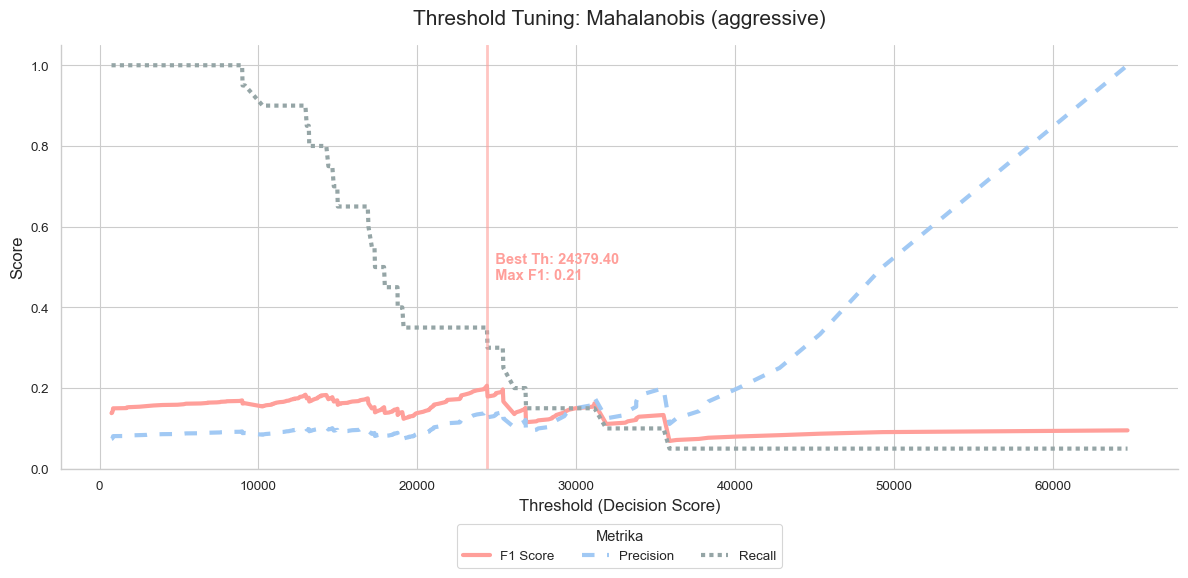

✅ The model was trained & tuned.
🎯 Optimal Threshold (Val): 24379.4049
📊 Best Validation F1:      0.2059
🎯 Optimal Threshold (Val): 24379.4049
Validation F1: 0.2059
✅ The model was trained & tuned.
🎯 Optimal Threshold (Val): 24379.4049
📊 Best Validation F1:      0.2059

📢 DETAILED CLASSIFICATION REPORT

🔹 TRAIN SET (L0 Only - Sanity Check)
   False Positives: 0 / 900 samples
   Error Rate (FPR): 0.00% (Mělo by být nízké)

🔹 VALIDATION SET (Used for tuning)
              precision    recall  f1-score   support

     Neutral     0.9372    0.8360    0.8837       250
     Anomaly     0.1277    0.3000    0.1791        20

    accuracy                         0.7963       270
   macro avg     0.5324    0.5680    0.5314       270
weighted avg     0.8773    0.7963    0.8315       270


🔹 TEST SET (Held-out data)
              precision    recall  f1-score   support

     Neutral     0.9470    0.8993    0.9225       695
     Anomaly     0.1358    0.2391    0.1732        46

    accuracy        

In [7]:
# 1. Get Winner
# Seřazení výsledků a výběr vítěze
best_run = results.sort_values('test_auprc', ascending=False).iloc[0]

print(f"🏆 WINNER: {best_run['model']} ({best_run['filter']})")
print(f"🌍 Scenario: {best_run['scenario']}")
print(f"⚙️ Params:   {best_run['params']}")
print(f"{'-'*30}")
print(f"📈 AUPRC:    {best_run['test_auprc']:.4f}")
print(f"📊 F1 Score: {best_run['test_f1']:.4f}")
print(f"🎯 Threshold:{best_run['val_threshold']:.4f}")

import ast
# V CSV jsou parametry jako text "{'method': 'empirical'}", musíme z toho udělat dict
try:
    winner_params = ast.literal_eval(best_run['params'])
except:
    winner_params = {}

# 2. Reload Data for Winner
data_best = data_splitting.get_unsupervised_splits(
    scenario=best_run['scenario'],   # <--- OPRAVA: Dynamický scénář (baseline/robustness)
    level='token', 
    filter_type=best_run['filter'],
    pooling='mean',
    random_state=42
)

# 3. Detailní výpis přímo v Notebooku (pokud bys nevěřil logům)
y_train = data_best['y_train']
y_val = data_best['y_val']
y_test = data_best['y_test']

print(f"\n📊 DATASET COMPOSITION:")
print(f"   Train: {len(y_train)} total | L0 (Neutral): {sum(y_train==0)} | L1 (Anomaly): {sum(y_train==1)} (Should be 0)")
print(f"   Val:   {len(y_val)} total  | L0: {sum(y_val==0)} ({sum(y_val==0)/len(y_val):.1%}) | L1: {sum(y_val==1)}")
print(f"   Test:  {len(y_test)} total | L0: {sum(y_test==0)} ({sum(y_test==0)/len(y_test):.1%}) | L1: {sum(y_test==1)}")

# Kontrola, že X_train je už čisté
print(f"📊 Data Loaded: Train={data_best['X_train'].shape}, Val={data_best['X_val'].shape}, Test={data_best['X_test'].shape}")

# 3. Retrain (S parametry vítěze!)
# X_train už obsahuje JENOM neutrální data (L0), takže nemusíme filtrovat
model = models.get_unsupervised_model(best_run['model'], **winner_params) # <--- OPRAVA: Předání parametrů
model.fit(data_best['X_train'])
print("✅ The model was trained.")

# 4. Get Scores
scores_val = model.decision_function(data_best['X_val'])
scores_test = model.decision_function(data_best['X_test'])

# 5. Optimal Threshold (Recalculate from Val just to be sure)
print(f"📊 Optimalizace prahu pro {best_run['model']}...")

threshold, val_f1 = visualization.plot_threshold_tuning(
    y_true=data_best['y_val'], 
    y_scores=scores_val,
    title=f"Threshold Tuning: {best_run['model']} ({best_run['filter']})",
    save_path=config.RESULTS_DIR / f"tuning_{best_run['model']}_{best_run['scenario']}.png"
)

print(f"✅ The model was trained & tuned.")
print(f"🎯 Optimal Threshold (Val): {threshold:.4f}")
print(f"📊 Best Validation F1:      {val_f1:.4f}")

# Teď můžeme práh bezpečně použít pro testovací data
y_pred_test = (scores_test > threshold).astype(int)

print(f"🎯 Optimal Threshold (Val): {threshold:.4f}")
print(f"Validation F1: {val_f1:.4f}")

print(f"✅ The model was trained & tuned.")
print(f"🎯 Optimal Threshold (Val): {threshold:.4f}")
print(f"📊 Best Validation F1:      {val_f1:.4f}")

# =============================================================================
# 6. FINAL PERFORMANCE REPORT
# =============================================================================

# 1. Aplikace prahu (Thresholding)
# Pro Train set nás zajímá, kolik % čistých dat model "omylem" označí (False Positives)
scores_train = model.decision_function(data_best['X_train'])
y_pred_train = (scores_train > threshold).astype(int)

# Pro Val a Test nás zajímá klasické metriky
y_pred_val = (scores_val > threshold).astype(int)
y_pred_test = (scores_test > threshold).astype(int)

print(f"\n{'='*60}")
print(f"📢 DETAILED CLASSIFICATION REPORT")
print(f"{'='*60}")

# --- A) TRAIN SET (sanity check) ---
# Tady očekáváme, že model nebude označovat nic. Vše, co označí, je chyba (FP).
n_fp_train = sum(y_pred_train)
fpr_train = n_fp_train / len(y_pred_train)
print(f"\n🔹 TRAIN SET (L0 Only - Sanity Check)")
print(f"   False Positives: {n_fp_train} / {len(y_pred_train)} samples")
print(f"   Error Rate (FPR): {fpr_train:.2%} (Mělo by být nízké)")

# --- B) VALIDATION SET ---
print(f"\n🔹 VALIDATION SET (Used for tuning)")
print(classification_report(data_best['y_val'], y_pred_val, target_names=['Neutral', 'Anomaly'], digits=4))

# --- C) TEST SET (Final Result) ---
print(f"\n🔹 TEST SET (Held-out data)")
print(classification_report(data_best['y_test'], y_pred_test, target_names=['Neutral', 'Anomaly'], digits=4))

# --- D) EXTRA METRICS (AUPRC, AUC) ---
metrics_test = evaluation.calculate_metrics(data_best['y_test'], y_pred_test, scores_test)

print(f"\n📈 FINAL TEST METRICS:")
print(f"   • ROC AUC: {metrics_test.get('roc_auc', 0):.4f}")
print(f"   • AUPRC:   {metrics_test.get('avg_precision', 0):.4f} (Důležité pro imbalanced data!)")
print(f"   • F1 Score:{metrics_test['f1']:.4f}")

### Visualizations

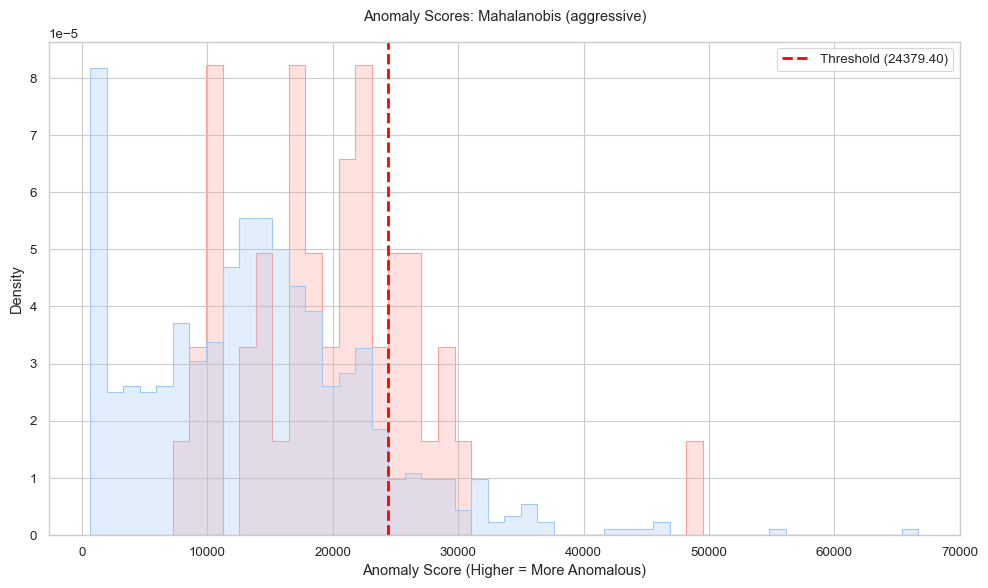

In [8]:
# 1. Anomaly Score Histogram
visualization.plot_anomaly_histogram(
    data_best['y_test'],   # <--- PRVNÍ musí být pravdivé labely (0/1)
    scores_test,           # <--- DRUHÉ musí být skóre (floaty)
    threshold=threshold,
    title=f"Anomaly Scores: {best_run['model']} ({best_run['filter']})"
)

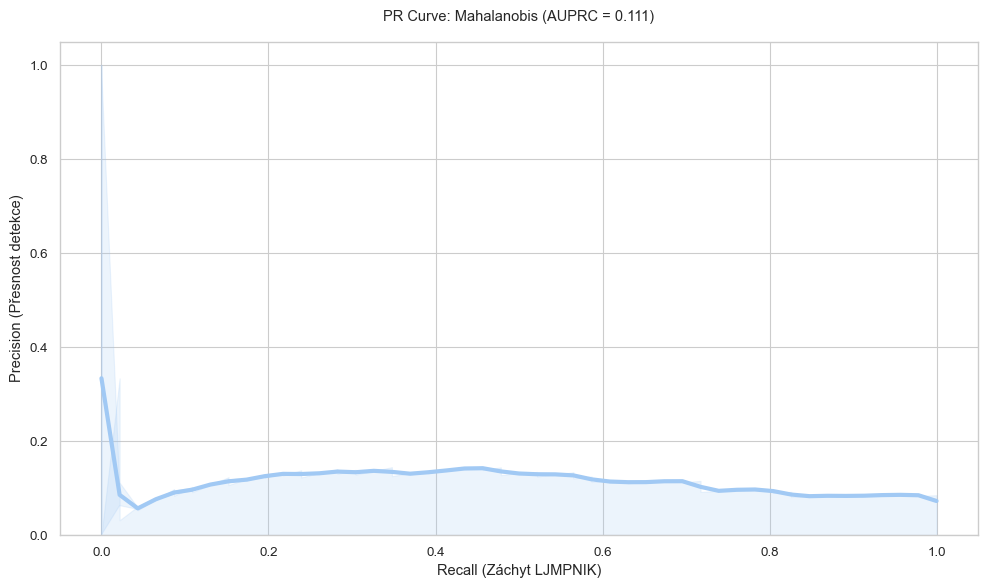

0.11119711403993475

In [9]:
# 2. Precision-Recall Curve
visualization.plot_pr_curve(
    data_best['y_test'], 
    scores_test, 
    title=f"PR Curve: {best_run['model']}"
)

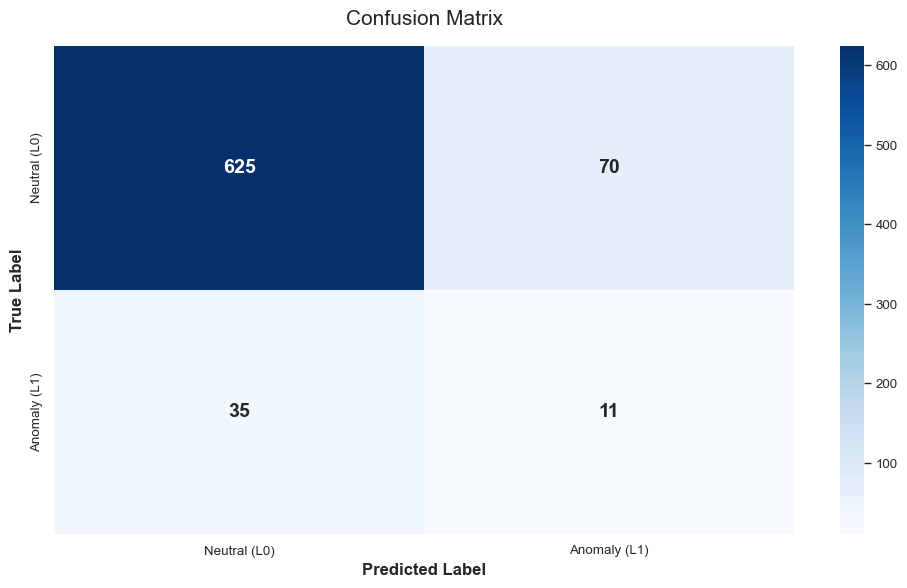

In [10]:
# 3. Confusion Matrix
y_pred_test = (scores_test > threshold).astype(int)
visualization.plot_confusion_matrix_heatmap(
    data_best['y_test'], 
    y_pred_test, 
    normalize=False
)

#### Embedding Projection

🎨 Počítám projekce pro Mahalanobis...


2026-02-04 11:17:55,646 - INFO - 1️⃣ Computing PCA...
2026-02-04 11:17:55,689 - INFO - 2️⃣ Computing t-SNE...
2026-02-04 11:18:03,132 - INFO - 3️⃣ Computing UMAP...



🔹 Vizualizace: PCA


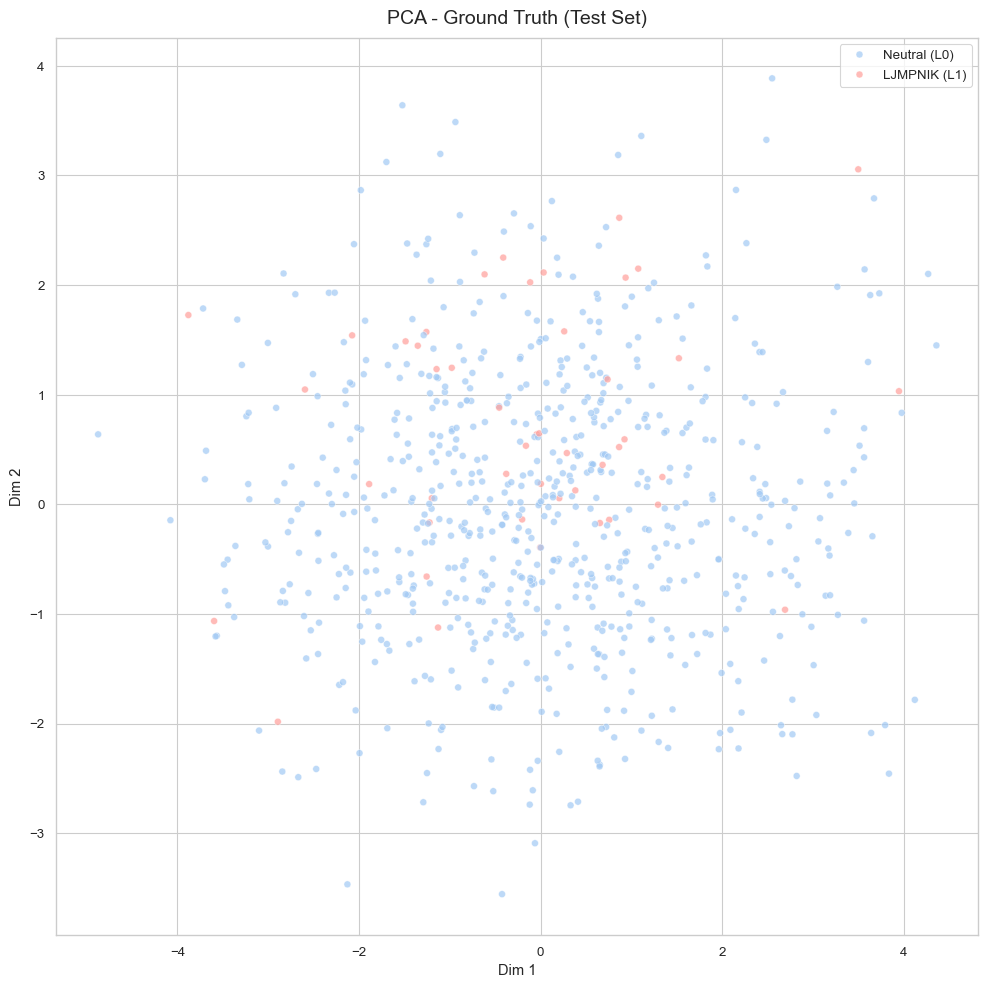

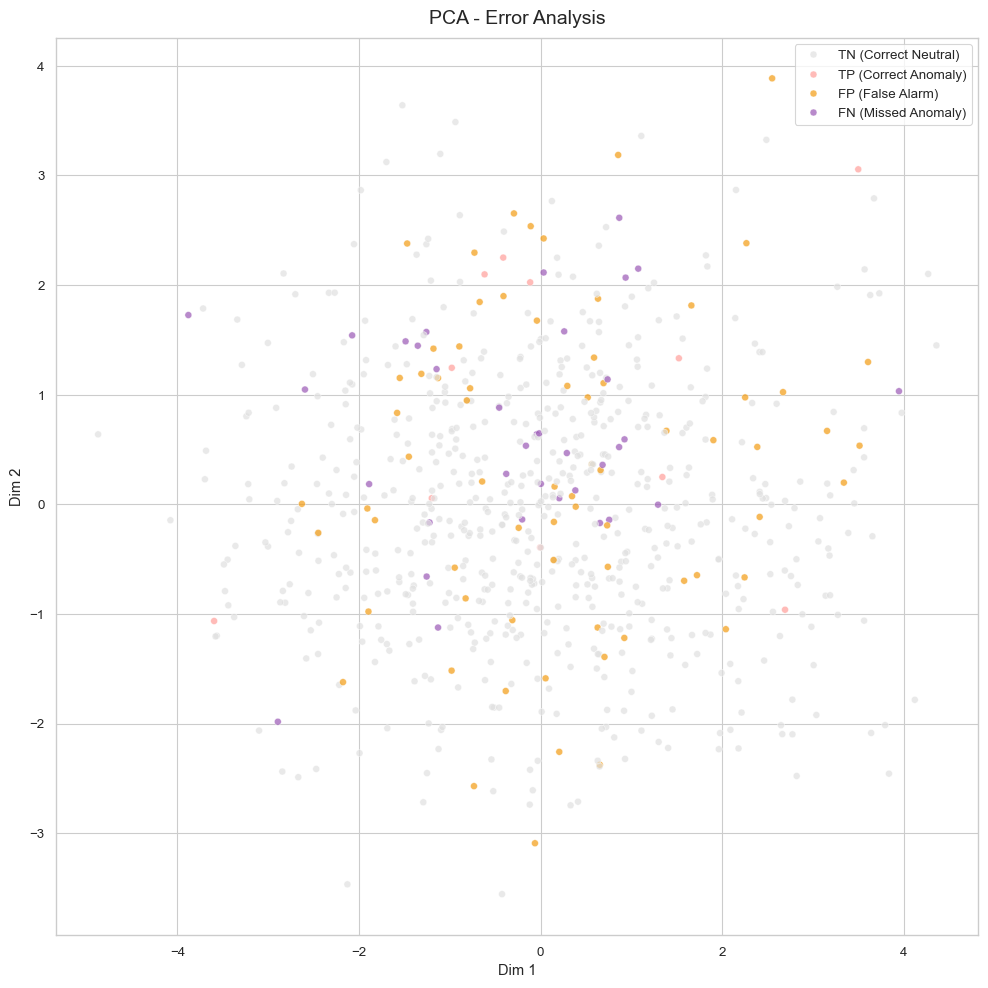


🔹 Vizualizace: t-SNE


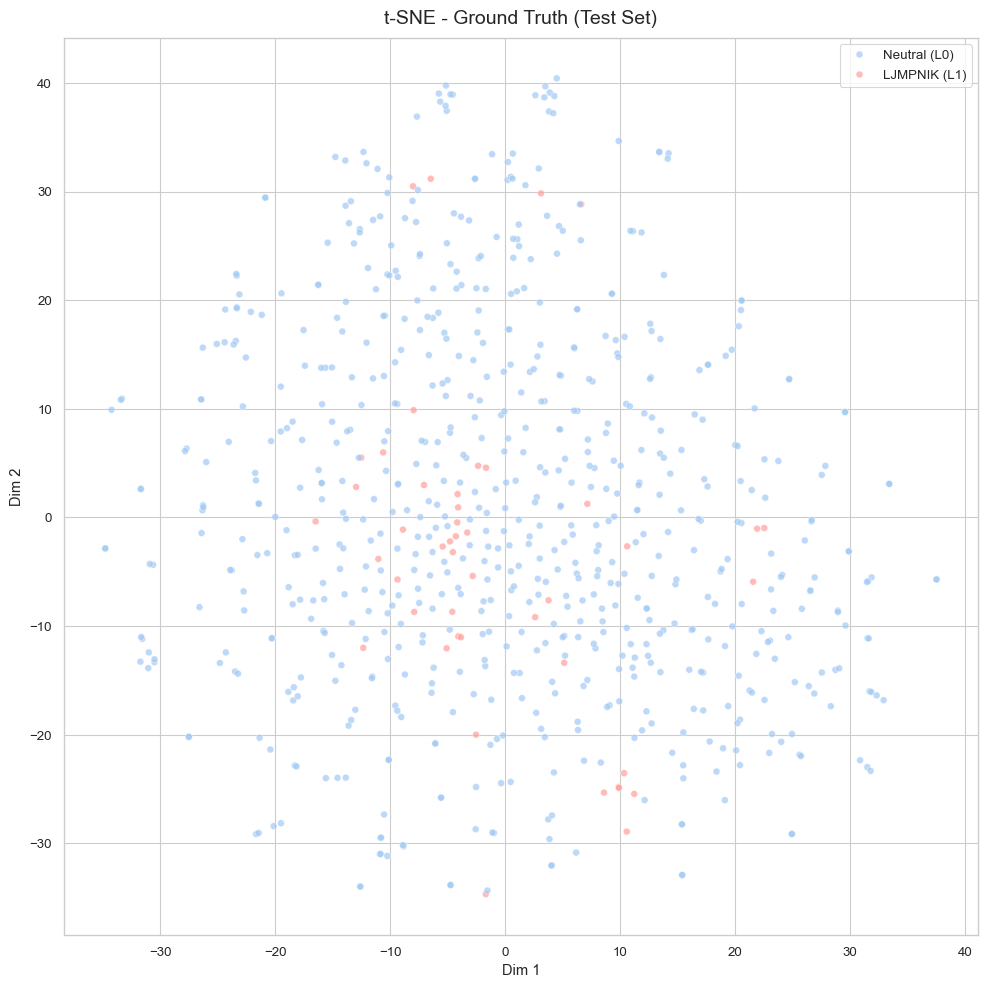

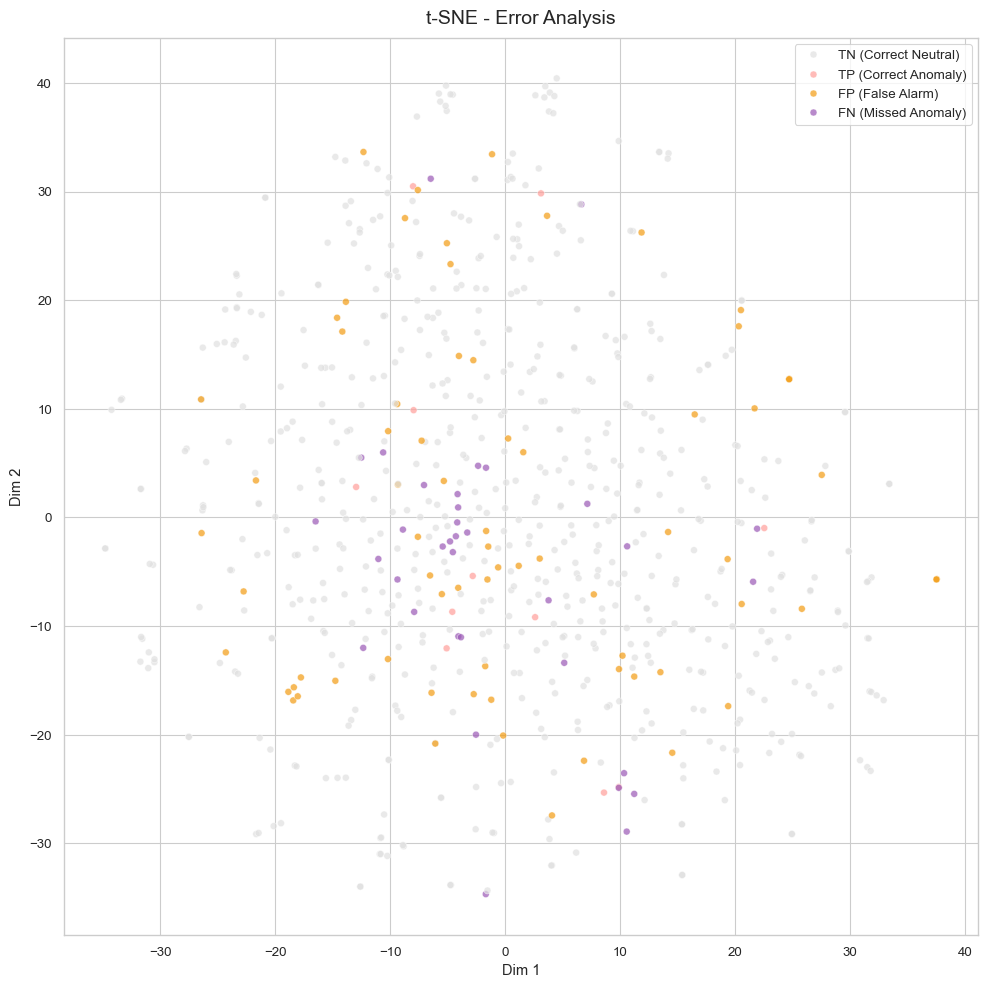


🔹 Vizualizace: UMAP


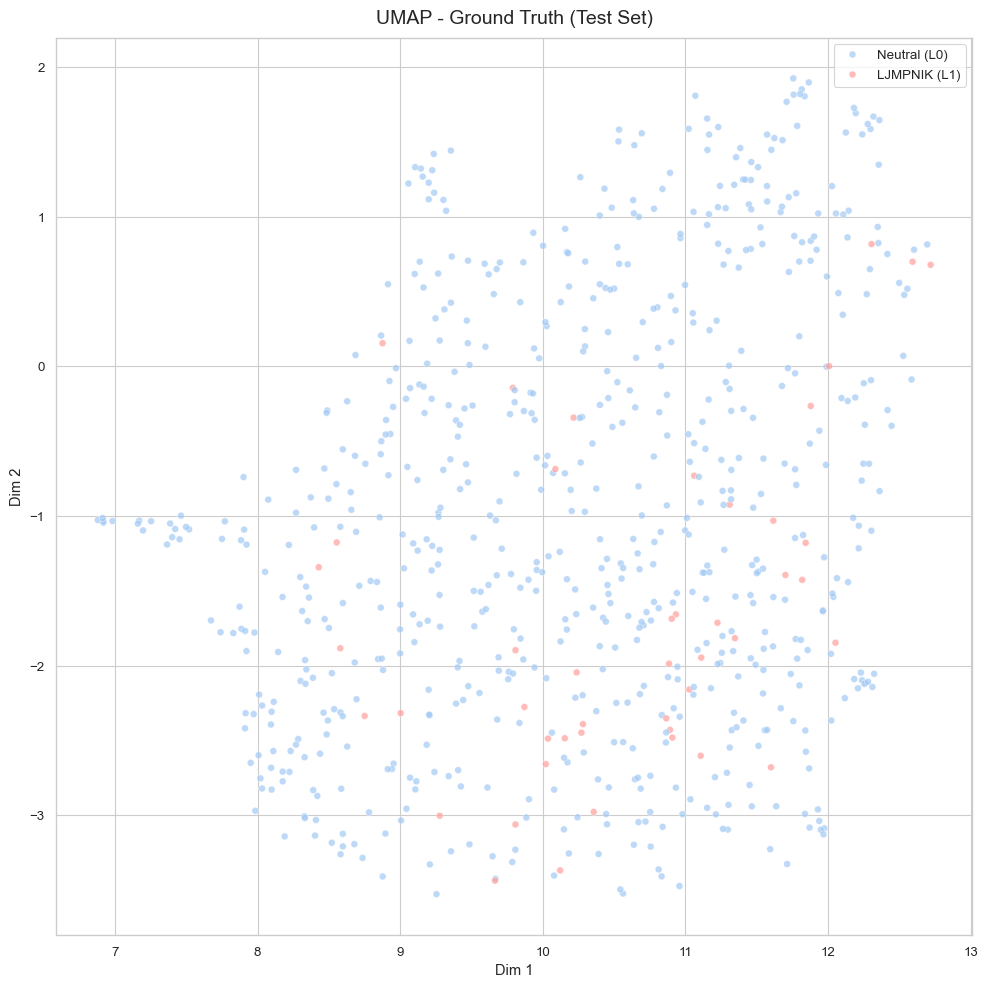

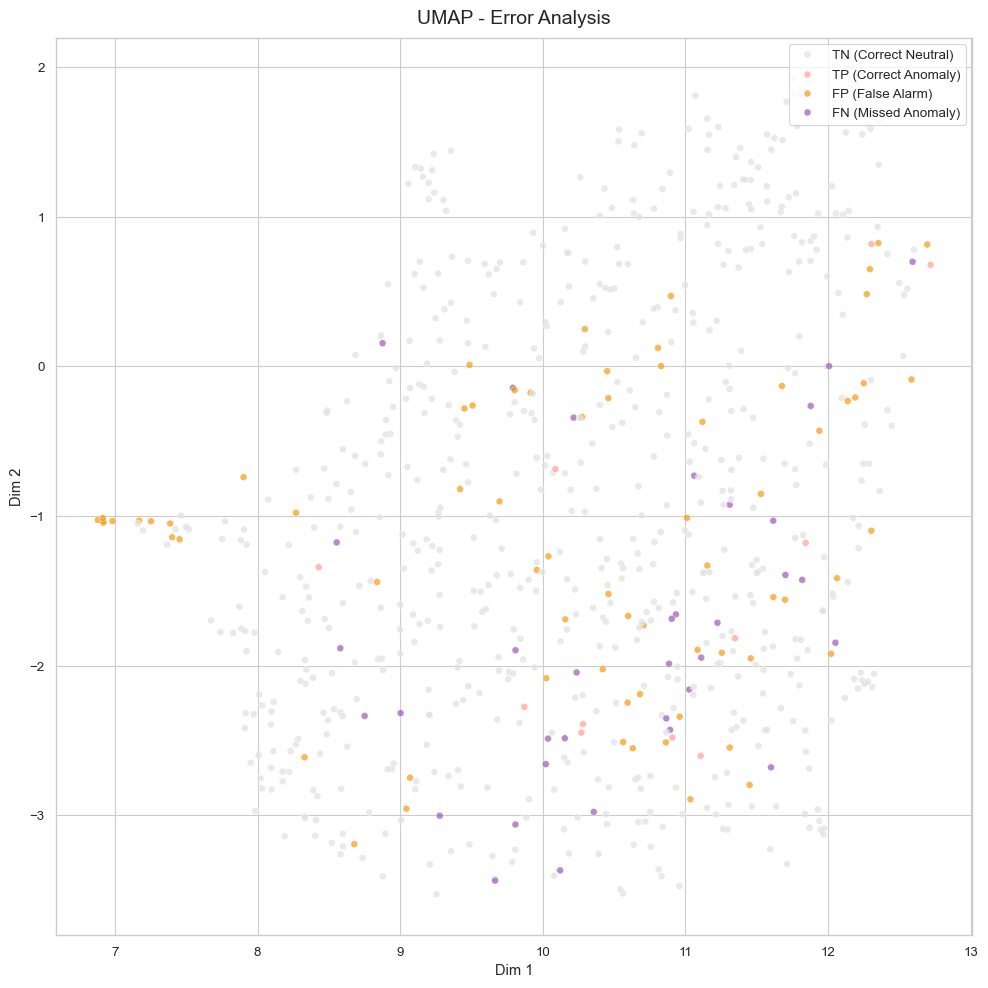


✅ Všechny projekce uloženy.


In [11]:
# =============================================================================
# 7. PROJEKCE EMBEDDINGŮ (PCA, t-SNE, UMAP)
# =============================================================================
print(f"🎨 Počítám projekce pro {best_run['model']}...")

# 1. Výpočet projekcí (pouze jednou!)
# Používáme X_test z vítězného modelu
# Funkce sama udělá subsampling (např. na 3000 bodů), aby to bylo rychlé
projections, indices = visualization.compute_projections(
    data_best['X_test'], 
    methods=['PCA', 't-SNE', 'UMAP'],
    random_state=42
)

# Musíme filtrovat i labely, abychom seděli na vybrané vzorky (pokud se subsamplovalo)
y_test_viz = data_best['y_test'][indices]
y_pred_viz = y_pred_test[indices]

# 2. Generování grafů (Loop přes metody)
for method, coords in projections.items():
    print(f"\n🔹 Vizualizace: {method}")
    
    # --- A) Ground Truth (Co to reálně je) ---
    # Připravíme labely
    labels_gt = pd.Series(y_test_viz).map({
        0: 'Neutral (L0)', 
        1: 'LJMPNIK (L1)'
    })
    
    visualization.plot_embedding_projection(
        coords=coords, 
        labels=labels_gt,
        palette={
            'Neutral (L0)': config.COLORS['l0'], 
            'LJMPNIK (L1)': config.COLORS['l1']
        },
        title=f"{method} - Ground Truth (Test Set)",
        hue_order=['Neutral (L0)', 'LJMPNIK (L1)'],
        save_path=config.RESULTS_DIR / f"proj_{method}_GT_{best_run['model']}.png"
    )
    
    # --- B) Error Analysis (Kde model chyboval) ---
    # Použijeme tvou novou specializovanou funkci
    visualization.plot_error_analysis_projection(
        coords=coords,
        y_true=y_test_viz,
        y_pred=y_pred_viz,
        method_name=method,
        save_path=config.RESULTS_DIR / f"proj_{method}_Errors_{best_run['model']}.png"
    )

print("\n✅ Všechny projekce uloženy.")

## 6. Qualitative Analysis (Export)

In [12]:
# =============================================================================
# 6. QUALITATIVE ERROR ANALYSIS (Proč to model spletl?)
# =============================================================================

# Vytvoříme DataFrame s výsledky
df_qual = pd.DataFrame({
    'text': data_best['meta_test']['text'],          # Samotné slovo
    'sentence': data_best['meta_test']['sentence'],  # Celá věta (kontext)
    'true_label': data_best['y_test'],
    'pred_label': (scores_test > threshold).astype(int),
    'anomaly_score': scores_test,
    'document_id': data_best['meta_test']['document_id']
})

# Přidáme kategorii chyby (TP, TN, FP, FN)
conditions = [
    (df_qual.true_label == 1) & (df_qual.pred_label == 1), # Trefil anomálii
    (df_qual.true_label == 0) & (df_qual.pred_label == 0), # Trefil neutral
    (df_qual.true_label == 0) & (df_qual.pred_label == 1), # Falešný poplach (FP)
    (df_qual.true_label == 1) & (df_qual.pred_label == 0)  # Minul anomálii (FN)
]
df_qual['category'] = np.select(conditions, ['TP', 'TN', 'FP', 'FN'])

# Seřadíme podle skóre (od nejvíce "podezřelých")
df_qual = df_qual.sort_values('anomaly_score', ascending=False)

# Uložíme
qual_path = config.RESULTS_DIR / f"M1_Qualitative_Analysis_{best_run['model']}.csv"
df_qual.to_csv(qual_path, index=False)

print(f"\n📝 Kvalitativní analýza uložena do: {qual_path}")
print("-" * 60)

# Rychlý náhled na nejhorší chyby (FP - Co označil špatně za anomálii?)
print("❌ TOP 5 FALSE POSITIVES (Model křičí 'Anomálie!', ale je to Neutral):")
print(df_qual[df_qual['category'] == 'FP'][['text', 'anomaly_score', 'sentence']].head(5))

print("\n❌ TOP 5 FALSE NEGATIVES (Model spal, ale byla to Anomálie):")
print(df_qual[df_qual['category'] == 'FN'][['text', 'anomaly_score', 'sentence']].tail(5)) # Tail, protože chceme ty s nejnižším skóre

KeyError: 'text'